In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [49]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [50]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [51]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [52]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [53]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [54]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        small_kernel_size = 3  
        big_kernel_size = 13
        
        self.decomposition1 = series_decomp(small_kernel_size)
        self.decomposition2 = series_decomp(big_kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
       
        # 현재는 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
        self.Linear_Seasonal = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init1,trend_init1 = self.decomposition1(x)
        seasonal_init2,trend_init2 = self.decomposition2(x)
        seasonal_init,trend_init = torch.cat([seasonal_init1,seasonal_init2],
                                             dim=2).to(self.device),torch.cat([trend_init1,
                                                                               trend_init2],dim=2).to(self.device)        
        seasonal_output = self.Linear_Seasonal(seasonal_init)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [55]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [56]:
torch.manual_seed(42)

In [57]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [58]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [59]:
torch.manual_seed(42)

In [60]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 189.6406728630526 %
smape 153.72148615967112 %
smape 100.3940156873381 %
smape 33.99536868938577 %
smape 23.744156472602782 %
smape 18.73464342838491 %
smape 15.980480037498893 %
smape 15.040341779066804 %
smape 13.75145250332286 %
smape 11.889391920109938 %
smape 10.956104760281523 %
smape 10.307622767592731 %
smape 10.17673227042831 %
smape 9.696629866957664 %
smape 9.466706159693455 %
smape 9.509260723291085 %
smape 10.039173565064258 %
smape 9.497451570037512 %
smape 9.125960141594646 %
smape 9.577660705698165 %
smape 9.56435763696481 %
smape 9.165782572494614 %
smape 9.235813560193046 %
smape 9.25954745701182 %
smape 9.190683865059189 %
smape 9.229533399580516 %
smape 9.426877450698997 %
smape 9.33700365324815 %
smape 9.188363722454735 %
smape 8.935931264831309 %
smape 9.047302097430704 %
smape 8.941321052305879 %
smape 8.994622365163083 %
smape 9.25925594324257 %
smape 9.241862996802693 %
smape 9.069062229136975 %
smape 9.009023542728341 %
smape 9.094982192530269 %
smape 9.

In [61]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.6778394913926604 %
SMAPE 2.0430828891549027 %
SMAPE 1.3725229245319497 %
SMAPE 1.4323736685910262 %
SMAPE 0.20186631045362446 %
SMAPE 0.587693663112077 %
SMAPE 1.5218217652436579 %
SMAPE 0.2560333650908433 %
SMAPE 0.7119138837442733 %
SMAPE 0.17784351041336777 %
SMAPE 0.35220205435825847 %
SMAPE 1.2053546469542198 %
SMAPE 1.101322427964078 %
SMAPE 0.41334429858397925 %
SMAPE 1.3416843181475997 %
SMAPE 1.3308024188008858 %
SMAPE 0.23838995707592403 %
SMAPE 1.788930581009481 %
SMAPE 1.3494671656353603 %
SMAPE 0.2619085324695334 %
SMAPE 1.6807566564893932 %
SMAPE 3.4445286214759103 %
SMAPE 1.1224145103333285 %
SMAPE 1.0968460680924181 %
SMAPE 0.968482275467977 %
SMAPE 1.6128578917359846 %
SMAPE 4.162378217020887 %
SMAPE 0.4647004502903656 %
SMAPE 0.36579995043985036 %
SMAPE 0.30215111435973085 %
SMAPE 0.30347523959790124 %
SMAPE 2.4716463554432266 %
SMAPE 0.45185666524776025 %
SMAPE 0.35355569635248685 %
SMAPE 0.15795865688596678 %
SMAPE 0.7309327885741368 %
SMAPE 0.99583004825581

SMAPE 0.7947744713637803 %
SMAPE 0.2164788944683096 %
SMAPE 1.2878146333096083 %
SMAPE 0.7352164589888162 %
SMAPE 0.7776703226627433 %
SMAPE 0.5462307083143969 %
SMAPE 0.12116527940088416 %
SMAPE 0.30091359723974165 %
SMAPE 0.07296508942681612 %
SMAPE 0.19556492220436894 %
SMAPE 1.0479392223860486 %
SMAPE 5.586922933500318 %
SMAPE 3.0946469812770374 %
SMAPE 5.250561309032491 %
SMAPE 5.618181045880192 %
SMAPE 0.5673592903347071 %
SMAPE 0.7439823610839085 %
SMAPE 0.31298108126065927 %
SMAPE 2.591537565604085 %
SMAPE 0.29761552901618415 %
SMAPE 0.9143694337362831 %
SMAPE 0.4176197676899278 %
SMAPE 1.5970275507861516 %
SMAPE 3.5893496700846304 %
SMAPE 2.5565835180568683 %
SMAPE 1.5871627398882993 %
SMAPE 1.2215552599154762 %
SMAPE 0.3103849192651751 %
SMAPE 3.176819209700625 %
SMAPE 0.3393853766101529 %
SMAPE 1.5111577688767284 %
SMAPE 1.1433761318112374 %
SMAPE 1.3623901066195003 %
SMAPE 1.3993066870461917 %
SMAPE 0.5408248203166295 %
SMAPE 0.5000712114642738 %
SMAPE 0.5995205416111276 %


SMAPE 0.41703475303438603 %
SMAPE 0.6976899317232892 %
SMAPE 0.552773615840124 %
SMAPE 0.609222888975637 %
SMAPE 0.5298132608750166 %
SMAPE 0.9221699629270006 %
SMAPE 1.5148158042306932 %
SMAPE 0.20020897389986203 %
SMAPE 0.18678054004340083 %
SMAPE 0.26822449364408385 %
SMAPE 1.0375399391186875 %
SMAPE 0.13695561862914474 %
SMAPE 0.9960040329751791 %
SMAPE 0.14840933334926376 %
SMAPE 0.5261874566058395 %
SMAPE 0.9051862594424165 %
SMAPE 0.16921360021660803 %
SMAPE 0.9443884952052031 %
SMAPE 0.6089380069242907 %
SMAPE 1.0395795560907573 %
SMAPE 1.5008384850807488 %
SMAPE 0.10481793692997599 %
SMAPE 0.23543149881948014 %
SMAPE 0.3205598089698469 %
SMAPE 0.6564779745694977 %
SMAPE 1.3526914585090708 %
SMAPE 1.757645559089724 %
SMAPE 1.4782716781082854 %
SMAPE 0.38741983644831635 %
SMAPE 0.8978896578482818 %
SMAPE 0.6378536309703122 %
SMAPE 0.1202707719439786 %
SMAPE 0.6810845327759125 %
SMAPE 0.6422120610150159 %
SMAPE 1.1727721344052497 %
SMAPE 0.5980751416736894 %
SMAPE 0.5060534592685

SMAPE 0.11404998598300152 %
SMAPE 0.1785879353474229 %
SMAPE 0.3222925039299298 %
SMAPE 0.28139426421694225 %
SMAPE 0.3437764475370386 %
SMAPE 0.1284694793518497 %
SMAPE 0.9198231295158621 %
SMAPE 0.920870422058215 %
SMAPE 1.1174870802351506 %
SMAPE 0.6134815763962251 %
SMAPE 0.3565744360203098 %
SMAPE 0.7911035325932971 %
SMAPE 0.1763114426039465 %
SMAPE 0.5762134430683545 %
SMAPE 0.3929672707224654 %
SMAPE 0.12208515143720432 %
SMAPE 0.9187617176212369 %
SMAPE 0.8469000017212238 %
SMAPE 0.6229800803703256 %
SMAPE 0.905089380553818 %
SMAPE 0.6178092713053047 %
SMAPE 0.17821435938822106 %
SMAPE 0.7481198691966711 %
SMAPE 0.41326386816217564 %
SMAPE 0.1669743809791271 %
SMAPE 0.3447072116778145 %
SMAPE 1.1865031751221977 %
SMAPE 0.7797601521124307 %
SMAPE 1.018157450016588 %
SMAPE 1.3104668367650447 %
SMAPE 0.18237239111090275 %
SMAPE 0.32457582935967366 %
SMAPE 0.9738230158836814 %
SMAPE 0.1579397126065487 %
SMAPE 0.463990285381442 %
SMAPE 0.1559928082369879 %
SMAPE 0.24399409575744357

SMAPE 1.3221631386386434 %
SMAPE 0.09424495677558298 %
SMAPE 0.3681526354739617 %
SMAPE 0.48216820822199224 %
SMAPE 0.5822015639757296 %
SMAPE 0.5796840869988955 %
SMAPE 0.27260885596854223 %
SMAPE 0.6315408498048782 %
SMAPE 1.6534318923104367 %
SMAPE 1.0090962506219512 %
SMAPE 0.3563979637983721 %
SMAPE 0.1254486618527153 %
SMAPE 0.5418078401389721 %
SMAPE 0.8174784537513915 %
SMAPE 1.18835120798758 %
SMAPE 0.26767145183657703 %
SMAPE 0.9340710656688315 %
SMAPE 0.9658981186230449 %
SMAPE 0.5648939950478962 %
SMAPE 0.48657031035691034 %
SMAPE 1.873449283237278 %
SMAPE 0.41498070723355346 %
SMAPE 0.6882421827021972 %
SMAPE 0.45376319995557424 %
SMAPE 0.29664876441893284 %
SMAPE 0.639296557274065 %
SMAPE 0.4389217454499886 %
SMAPE 1.151530200149864 %
SMAPE 1.1981622939783847 %
SMAPE 0.2550760801641445 %
SMAPE 2.2379775529916515 %
SMAPE 0.9618331122655945 %
SMAPE 0.669188882362505 %
SMAPE 0.9406626225809305 %
SMAPE 1.5267930913396413 %
SMAPE 0.8697710757987807 %
SMAPE 0.4070644233270287 %

SMAPE 0.19399279000936076 %
SMAPE 0.5110793864660081 %
SMAPE 0.3227381734404844 %
SMAPE 0.26145349079888547 %
SMAPE 0.24579114139942249 %
SMAPE 0.3736779315477179 %
SMAPE 0.3755013843492634 %
SMAPE 0.312007804550376 %
SMAPE 0.6201525657415914 %
SMAPE 0.18434115944319274 %
SMAPE 0.24981490124082484 %
SMAPE 2.360107496539513 %
SMAPE 0.6152227514176047 %
SMAPE 0.7817552211836301 %
SMAPE 0.544974777239986 %
SMAPE 0.37677486382563075 %
SMAPE 0.15514414222161577 %
SMAPE 1.5663243549061008 %
SMAPE 1.8637334057348198 %
SMAPE 0.19870881051156172 %
SMAPE 0.179181228073503 %
SMAPE 1.1091168987595665 %
SMAPE 0.2626104882265281 %
SMAPE 0.8444816962446566 %
SMAPE 0.37398524330455984 %
SMAPE 0.3370053453472792 %
SMAPE 0.33523466935002944 %
SMAPE 0.8576841761869218 %
SMAPE 0.852203814585664 %
SMAPE 0.15596796984482353 %
SMAPE 0.34078992628565175 %
SMAPE 0.21654773551563264 %
SMAPE 0.2836533483589392 %
SMAPE 0.22850060419477813 %
SMAPE 0.18097183164167063 %
SMAPE 0.2990871515175968 %
SMAPE 0.4110066662

SMAPE 0.8093885001126183 %
SMAPE 1.2955197461806165 %
SMAPE 0.33364562754786675 %
SMAPE 0.7916002778047185 %
SMAPE 0.7381960269412957 %
SMAPE 0.7509761626997715 %
SMAPE 1.7302595920555177 %
SMAPE 0.4030728761167665 %
SMAPE 0.8644370337169676 %
SMAPE 1.0044620075204875 %
SMAPE 0.4722090251016197 %
SMAPE 0.5968982616232097 %
SMAPE 0.21064087944432686 %
SMAPE 0.5543228266342339 %
SMAPE 0.8424596557742916 %
SMAPE 2.0104707818245515 %
SMAPE 1.0742427949153353 %
SMAPE 0.3551160287224775 %
SMAPE 4.197203715404385 %
SMAPE 6.40317933645565 %
SMAPE 3.705546140576189 %
SMAPE 0.5774466489706356 %
SMAPE 0.44787688799806347 %
SMAPE 0.9465276396986155 %
SMAPE 0.3428515135036605 %
SMAPE 1.2816035184932844 %
SMAPE 0.15629346061541582 %
SMAPE 0.19115078222603188 %
SMAPE 0.4461819546306743 %
SMAPE 0.9316849484275737 %
SMAPE 0.7435027683823137 %
SMAPE 1.1384996009073802 %
SMAPE 0.6147095018750406 %
SMAPE 0.3450636195948391 %
SMAPE 1.7702598470277733 %
SMAPE 3.4186412836788804 %
SMAPE 0.5921566435154091 %


SMAPE 0.33899763044610154 %
SMAPE 0.8851792271161684 %
SMAPE 0.7784149808230723 %
SMAPE 1.0088262977878912 %
SMAPE 3.2035023527932935 %
SMAPE 6.251937731401995 %
SMAPE 1.2062366479076445 %
SMAPE 1.0008085872905212 %
SMAPE 0.5026618730189512 %
SMAPE 0.8626744582725223 %
SMAPE 0.1537769215683511 %
SMAPE 0.2858116054558195 %
SMAPE 0.48754611500953615 %
SMAPE 2.1933168923133053 %
SMAPE 0.5087550549214939 %
SMAPE 0.7748301374510902 %
SMAPE 0.22358227931181315 %
SMAPE 0.4018679399418943 %
SMAPE 0.4779929995966086 %
SMAPE 0.3059453552141349 %
SMAPE 0.391755802789703 %
SMAPE 0.1839420098294795 %
SMAPE 0.18088028865122396 %
SMAPE 0.3855469077025191 %
SMAPE 0.31417385229678985 %
SMAPE 0.2511869111085616 %
SMAPE 0.24545707767674685 %
SMAPE 0.543342946744815 %
SMAPE 0.25090390764125914 %
SMAPE 0.6377515747549296 %
SMAPE 0.27027199441363337 %
SMAPE 0.18956234640245384 %
SMAPE 0.18920583786712086 %
SMAPE 0.8398124871382606 %
SMAPE 0.38282788704418635 %
SMAPE 0.36831075255031465 %
SMAPE 0.10841681643

SMAPE 0.1700310721898859 %
SMAPE 0.5279378107441062 %
SMAPE 1.936424789029843 %
SMAPE 2.1436722976723104 %
SMAPE 2.76876689664914 %
SMAPE 0.44212440037517803 %
SMAPE 2.3811994796051295 %
SMAPE 1.7533597128640395 %
SMAPE 1.1925292342980356 %
SMAPE 1.07133511471784 %
SMAPE 0.6786710289957227 %
SMAPE 0.38529748456494417 %
SMAPE 3.031095371916308 %
SMAPE 0.5256121983366029 %
SMAPE 2.2110917096797493 %
SMAPE 0.7532476752458024 %
SMAPE 0.8478058620094089 %
SMAPE 0.1597595021557936 %
SMAPE 0.5785730305651668 %
SMAPE 0.15964877588203308 %
SMAPE 0.4121058446908137 %
SMAPE 0.3148131796060625 %
SMAPE 0.6194413526973221 %
SMAPE 0.22485944345514494 %
SMAPE 0.1434230719351035 %
SMAPE 0.6963666218407525 %
SMAPE 0.3351611211546697 %
SMAPE 0.8932628165421193 %
SMAPE 0.42436410410664394 %
SMAPE 0.34429801971236884 %
SMAPE 0.6490042918558174 %
SMAPE 0.13415077105219098 %
SMAPE 2.1877015536774707 %
SMAPE 0.2457636709077633 %
SMAPE 0.2808093695930438 %
SMAPE 0.5002360671205679 %
SMAPE 2.0817503867110645 %


SMAPE 0.2580782986403847 %
SMAPE 1.6032005857268814 %
SMAPE 0.3863355747234891 %
SMAPE 0.4102677942355513 %
SMAPE 0.34909467289219265 %
SMAPE 0.5616745534109668 %
SMAPE 0.5930666302887175 %
SMAPE 0.34845930227675126 %
SMAPE 0.785372175188968 %
SMAPE 2.2921854832893587 %
SMAPE 0.9441003106694552 %
SMAPE 0.7108874847008337 %
SMAPE 1.1598219245643122 %
SMAPE 1.325872729976254 %
SMAPE 0.3809464703899721 %
SMAPE 0.4980557951039372 %
SMAPE 0.8032739678201324 %
SMAPE 0.1712740584544008 %
SMAPE 0.2836284302320564 %
SMAPE 0.6983611668256344 %
SMAPE 0.530934251160943 %
SMAPE 0.8348758237152651 %
SMAPE 0.1418418871035101 %
SMAPE 0.3650402304592717 %
SMAPE 0.5322765027594869 %
SMAPE 0.17961554376506683 %
SMAPE 0.4553279662741261 %
SMAPE 0.3649366706904402 %
SMAPE 0.1293784226409116 %
SMAPE 0.7386516478409249 %
SMAPE 0.42138250461721327 %
SMAPE 0.6736918536171288 %
SMAPE 0.39284824044807465 %
SMAPE 0.7787576112023089 %
SMAPE 0.2260858975987503 %
SMAPE 0.8358040866514784 %
SMAPE 0.8027686302157235 %

SMAPE 1.3818196059874026 %
SMAPE 0.20683238834089934 %
SMAPE 0.7544069375235267 %
SMAPE 0.4477593248072936 %
SMAPE 1.2473716210242856 %
SMAPE 0.6085346660393043 %
SMAPE 2.5329608514148276 %
SMAPE 0.24367101222196652 %
SMAPE 0.638322433711437 %
SMAPE 1.284239021124904 %
SMAPE 0.46586624841984303 %
SMAPE 0.26064515783491515 %
SMAPE 0.2291054926254219 %
SMAPE 0.7656661742257711 %
SMAPE 0.725934899243839 %
SMAPE 0.8794749373191736 %
SMAPE 1.306733355335382 %
SMAPE 0.2520377562104841 %
SMAPE 0.5155336216412252 %
SMAPE 0.9411967262349209 %
SMAPE 0.5330782532037119 %
SMAPE 0.4429094767838251 %
SMAPE 0.45780283239082564 %
SMAPE 0.29571032323656254 %
SMAPE 0.30578050952681224 %
SMAPE 0.1973750105044019 %
SMAPE 1.2580831515224418 %
SMAPE 0.1911690778870252 %
SMAPE 0.4713677493302839 %
SMAPE 0.4730868480937716 %
SMAPE 0.4626598892900802 %
SMAPE 0.4569571305003137 %
SMAPE 0.5043213358130743 %
SMAPE 1.1180470606868766 %
SMAPE 0.6035129518768372 %
SMAPE 0.3294504175282782 %
SMAPE 1.1594783437981278 

SMAPE 0.33890312087442 %
SMAPE 0.32440150450202054 %
SMAPE 0.5563236906154998 %
SMAPE 0.4318800802138867 %
SMAPE 2.655946363520343 %
SMAPE 0.577510122966487 %
SMAPE 0.4706583742918155 %
SMAPE 0.4292822504703508 %
SMAPE 0.39989605895061686 %
SMAPE 0.6705007910156837 %
SMAPE 0.9671299744155704 %
SMAPE 0.44118701489060186 %
SMAPE 0.7432739581709029 %
SMAPE 0.2397135078017527 %
SMAPE 1.4366415149124805 %
SMAPE 0.35345962876453996 %
SMAPE 0.20532680766700648 %
SMAPE 0.13403334160011582 %
SMAPE 0.5419994156779921 %
SMAPE 0.6302336251155793 %
SMAPE 0.29327529720285384 %
SMAPE 0.4144319618317241 %
SMAPE 0.43722237558904453 %
SMAPE 0.18843884392845212 %
SMAPE 0.6914957997560123 %
SMAPE 0.2104890877776029 %
SMAPE 0.24764890244841808 %
SMAPE 0.26969904409429546 %
SMAPE 1.0983945564585156 %
SMAPE 0.1592569646818447 %
SMAPE 0.47358160745989153 %
SMAPE 0.6693994050074252 %
SMAPE 0.8786304605127953 %
SMAPE 0.08416951213007451 %
SMAPE 3.204010858360561 %
SMAPE 0.3760184712746195 %
SMAPE 0.572013765537

SMAPE 0.46555975879891776 %
SMAPE 1.3677515825147566 %
SMAPE 2.779564227624178 %
SMAPE 0.4483410073480627 %
SMAPE 0.30936020345143334 %
SMAPE 0.4937874213210307 %
SMAPE 0.5697208958840818 %
SMAPE 0.7167344395160171 %
SMAPE 1.6356367625667187 %
SMAPE 0.17498685056852992 %
SMAPE 0.21450103792813022 %
SMAPE 0.9186835308937589 %
SMAPE 0.8612655442448158 %
SMAPE 2.131000350380873 %
SMAPE 0.3707290813072177 %
SMAPE 0.38327266168380447 %
SMAPE 0.8781941752677085 %
SMAPE 0.6213332767301836 %
SMAPE 0.1121800177060095 %
SMAPE 0.6632360894561771 %
SMAPE 0.38943587054745876 %
SMAPE 1.1627248990080261 %
SMAPE 2.730357723805355 %
SMAPE 0.31565957735074335 %
SMAPE 0.3543530983772598 %
SMAPE 0.2902101342824608 %
SMAPE 0.9978014654225262 %
SMAPE 0.7872709102184673 %
SMAPE 0.8068174448926584 %
SMAPE 0.5456363247940317 %
SMAPE 0.3421651516937345 %
SMAPE 0.09247728939408262 %
SMAPE 2.922771937001471 %
SMAPE 0.2357599178540113 %
SMAPE 0.7117369950246939 %
SMAPE 0.6310583120721276 %
SMAPE 0.1813506552352919

SMAPE 2.164435711718397 %
SMAPE 0.29548563811476924 %
SMAPE 0.6257347568935074 %
SMAPE 0.5133586233450842 %
SMAPE 0.4255290839082591 %
SMAPE 0.22025476000817434 %
SMAPE 0.41394215858963435 %
SMAPE 0.39151764733469463 %
SMAPE 0.7871158082007241 %
SMAPE 0.3564792244324053 %
SMAPE 2.1682949365640525 %
SMAPE 0.3179156370351848 %
SMAPE 0.17185310132299492 %
SMAPE 0.20632185379326984 %
SMAPE 0.32289738938197843 %
SMAPE 0.4286775020177629 %
SMAPE 0.19543252721632595 %
SMAPE 0.1645518406573956 %
SMAPE 0.20617701600713192 %
SMAPE 0.15698971226083813 %
SMAPE 1.2247916431952035 %
SMAPE 0.8637745082669426 %
SMAPE 0.8074085852822463 %
SMAPE 0.41205266365068377 %
SMAPE 0.557038667310735 %
SMAPE 0.23397641264637062 %
SMAPE 1.2175715018856863 %
SMAPE 0.1703434867231408 %
SMAPE 0.3995966911006689 %
SMAPE 0.4219183873519796 %
SMAPE 1.515682968703004 %
SMAPE 0.6381756429909728 %
SMAPE 0.7891502209409963 %
SMAPE 0.5182738107614568 %
SMAPE 0.4698406638926827 %
SMAPE 0.4631394605694368 %
SMAPE 0.56442078800

SMAPE 1.0104918566794368 %
SMAPE 0.22934601944598398 %
SMAPE 0.5692967418945045 %
SMAPE 0.24671958244834968 %
SMAPE 0.42105088018979586 %
SMAPE 0.8309735475686466 %
SMAPE 0.1650257136872142 %
SMAPE 0.4434779848543258 %
SMAPE 0.17765699453957495 %
SMAPE 0.17685719277505996 %
SMAPE 0.32455619373649824 %
SMAPE 0.14893508045133785 %
SMAPE 0.342391479483922 %
SMAPE 0.23485059130331365 %
SMAPE 0.9889622129121564 %
SMAPE 0.1985278076165287 %
SMAPE 0.29061259735681233 %
SMAPE 1.5190501921460964 %
SMAPE 0.7666106552569545 %
SMAPE 1.352217678213492 %
SMAPE 0.4334898404631531 %
SMAPE 0.41342116530813655 %
SMAPE 0.7659837569881347 %
SMAPE 0.6349659765105571 %
SMAPE 1.135754090410046 %
SMAPE 0.34628700442044646 %
SMAPE 0.35265607737892424 %
SMAPE 0.8034272132827027 %
SMAPE 0.9547168576173135 %
SMAPE 2.4963409580650477 %
SMAPE 0.5969770913798129 %
SMAPE 0.5870606929975111 %
SMAPE 0.43193309908019734 %
SMAPE 0.33386678407987347 %
SMAPE 0.9870702391344821 %
SMAPE 0.9517625164007768 %
SMAPE 2.274898827

SMAPE 1.0223871834896272 %
SMAPE 0.21481394202237425 %
SMAPE 0.47982740740189916 %
SMAPE 0.4095942453668613 %
SMAPE 0.9821825022081612 %
SMAPE 0.1127373771978455 %
SMAPE 0.7043086172070616 %
SMAPE 0.3346394341861014 %
SMAPE 1.315971886193438 %
SMAPE 1.152416809454735 %
SMAPE 0.8646905399782554 %
SMAPE 0.5748066282849322 %
SMAPE 1.4944511395224254 %
SMAPE 1.184226629557088 %
SMAPE 0.2520141585446254 %
SMAPE 1.4924506540162383 %
SMAPE 1.7206300034595188 %
SMAPE 0.2863686160344514 %
SMAPE 0.11898217615998873 %
SMAPE 2.0219433353316845 %
SMAPE 0.6653920967655722 %
SMAPE 1.637133623182308 %
SMAPE 4.590467348536549 %
SMAPE 5.931455594080035 %
SMAPE 4.361026521684835 %
SMAPE 0.9121906805798972 %
SMAPE 3.7565899834080483 %
SMAPE 0.4048263456679706 %
SMAPE 0.4680173591368657 %
SMAPE 0.7865904499121825 %
SMAPE 0.4375881847254277 %
SMAPE 0.5868145944950811 %
SMAPE 0.5474548472266179 %
SMAPE 1.6052516193158224 %
SMAPE 1.2162266391005687 %
SMAPE 0.9527368680064683 %
SMAPE 3.264697405271818 %
SMAPE 

SMAPE 0.2018137765840038 %
SMAPE 0.889852815098493 %
SMAPE 0.5424757239325118 %
SMAPE 0.9468634460936299 %
SMAPE 0.16561218547212775 %
SMAPE 0.18425175936363303 %
SMAPE 1.6030697287860676 %
SMAPE 5.492292916082079 %
SMAPE 0.7413492585656059 %
SMAPE 0.3122641698082589 %
SMAPE 0.4937858698394848 %
SMAPE 0.8119730359430832 %
SMAPE 1.3674192948674317 %
SMAPE 0.5469319888072022 %
SMAPE 1.8599278282636078 %
SMAPE 0.21343118533513916 %
SMAPE 0.10405223688940168 %
SMAPE 0.22779191539120802 %
SMAPE 0.9601464032166406 %
SMAPE 0.34835005218337756 %
SMAPE 0.5631040967485887 %
SMAPE 1.0766502184324054 %
SMAPE 0.2339439955085254 %
SMAPE 2.6488140923538595 %
SMAPE 0.3075709812437708 %
SMAPE 0.15569271311323973 %
SMAPE 0.6629580645903843 %
SMAPE 1.1805730516853146 %
SMAPE 0.5954048917660657 %
SMAPE 0.5564597901575326 %
SMAPE 0.30780476313475447 %
SMAPE 0.19721250402517398 %
SMAPE 0.7848060721998991 %
SMAPE 0.758695218784851 %
SMAPE 0.514742100451258 %
SMAPE 0.32259157687167317 %
SMAPE 0.15226985258050

SMAPE 0.5139192652695783 %
SMAPE 0.8247554824483814 %
SMAPE 0.5818896911587217 %
SMAPE 0.6611957805107522 %
SMAPE 0.717226522108831 %
SMAPE 0.12100627425024868 %
SMAPE 0.6379848146862059 %
SMAPE 0.5980694874133405 %
SMAPE 0.6824655418949988 %
SMAPE 0.20280518122126526 %
SMAPE 0.14527536645982764 %
SMAPE 0.27740310613626207 %
SMAPE 0.8810098224194007 %
SMAPE 1.5665777421472742 %
SMAPE 1.2004353157026344 %
SMAPE 0.21867047734122025 %
SMAPE 0.2463907567289425 %
SMAPE 0.9413013687953935 %
SMAPE 0.4433903561603074 %
SMAPE 0.2463325773642282 %
SMAPE 0.12656869972124696 %
SMAPE 0.7264126698365772 %
SMAPE 0.1302112303510512 %
SMAPE 0.30826650972812786 %
SMAPE 0.22462333361181666 %
SMAPE 0.9179319109753123 %
SMAPE 0.21428350383030192 %
SMAPE 0.6216727158571302 %
SMAPE 1.0518751082272502 %
SMAPE 0.3888223796825514 %
SMAPE 0.21326043986482549 %
SMAPE 0.6994211050455306 %
SMAPE 0.502598130984552 %
SMAPE 0.5796740039354518 %
SMAPE 0.26157230582248303 %
SMAPE 0.6232317367903306 %
SMAPE 0.68108025155

SMAPE 0.9771610861871523 %
SMAPE 0.4504767599742081 %
SMAPE 0.09857293791992561 %
SMAPE 0.760733614617493 %
SMAPE 1.0899459224601742 %
SMAPE 0.21518779818688927 %
SMAPE 0.10851476116295088 %
SMAPE 0.6528997430723393 %
SMAPE 0.6360815107473172 %
SMAPE 0.9365208368417371 %
SMAPE 0.3357691805895229 %
SMAPE 0.2179516052092367 %
SMAPE 0.17443023192390683 %
SMAPE 1.4593032947050233 %
SMAPE 2.1618203036196064 %
SMAPE 0.9179823499862324 %
SMAPE 0.22873572735988998 %
SMAPE 0.4212806705327239 %
SMAPE 0.791041187774681 %
SMAPE 1.6967439365203063 %
SMAPE 0.35737904381494445 %
SMAPE 0.4497778798818217 %
SMAPE 1.1470995941890578 %
SMAPE 0.333370782361726 %
SMAPE 0.12709192532929592 %
SMAPE 1.8687983187992359 %
SMAPE 0.7313016141706612 %
SMAPE 0.2945783401637527 %
SMAPE 0.36015375336961597 %
SMAPE 0.30466443883778993 %
SMAPE 0.1598947722433195 %
SMAPE 0.9024587749408965 %
SMAPE 0.26238750389165943 %
SMAPE 0.18912843534053536 %
SMAPE 0.9429479773825734 %
SMAPE 0.3924414496104873 %
SMAPE 0.114242386776

SMAPE 0.5265032014922326 %
SMAPE 0.705660256561714 %
SMAPE 1.9831012717695558 %
SMAPE 0.7352159680522163 %
SMAPE 0.7890795995772351 %
SMAPE 0.857529593560173 %
SMAPE 0.12926134251392796 %
SMAPE 0.46976117100712145 %
SMAPE 1.1474625800001377 %
SMAPE 0.5378480934377876 %
SMAPE 0.13633244921038568 %
SMAPE 0.26865358585928334 %
SMAPE 1.8630065437700978 %
SMAPE 0.5983470886603754 %
SMAPE 0.28997116649225063 %
SMAPE 1.0058435450373509 %
SMAPE 0.4961992634799373 %
SMAPE 1.063177471907693 %
SMAPE 1.5210842614596913 %
SMAPE 0.46781842287646214 %
SMAPE 0.4058796035644008 %
SMAPE 0.6550392327262671 %
SMAPE 0.21944476789303738 %
SMAPE 0.4294715314526912 %
SMAPE 0.31774642080290505 %
SMAPE 0.4112529723615807 %
SMAPE 0.3537640645772626 %
SMAPE 1.134262909028621 %
SMAPE 0.11474203233046865 %
SMAPE 0.42867174351067666 %
SMAPE 1.1244294002062816 %
SMAPE 0.5768024430781225 %
SMAPE 2.1956920440497925 %
SMAPE 0.5088676988671068 %
SMAPE 0.634105757264706 %
SMAPE 0.6766904292630898 %
SMAPE 0.943629273016995

SMAPE 0.9962714680441422 %
SMAPE 1.9471645654721215 %
SMAPE 0.5864039533371397 %
SMAPE 0.5472106191155035 %
SMAPE 0.049750947755455854 %
SMAPE 0.3797733210305978 %
SMAPE 0.34811987645844056 %
SMAPE 0.3371847634352889 %
SMAPE 1.9122696612030268 %
SMAPE 0.14540080830920488 %
SMAPE 0.13105243036989123 %
SMAPE 0.44332228839630256 %
SMAPE 0.2898049482337228 %
SMAPE 0.5745351550158375 %
SMAPE 0.1171074111080088 %
SMAPE 1.105042940180283 %
SMAPE 1.0307839866072754 %
SMAPE 5.311537993024103 %
SMAPE 0.40776722564623924 %
SMAPE 0.6225919272110332 %
SMAPE 0.18036696581998513 %
SMAPE 1.233726438760641 %
SMAPE 1.5550253299152246 %
SMAPE 1.0307406444480876 %
SMAPE 0.17960892613700707 %
SMAPE 0.38112703020624394 %
SMAPE 2.2098269856869592 %
SMAPE 5.847524960288865 %
SMAPE 0.2627457180642523 %
SMAPE 0.5701865523978995 %
SMAPE 0.3494574589021795 %
SMAPE 0.4597991344398906 %
SMAPE 1.674572401672776 %
SMAPE 0.700615026829837 %
SMAPE 0.24957582140996237 %
SMAPE 1.074872247712392 %
SMAPE 2.8264353104823385

SMAPE 0.3824299905591033 %
SMAPE 0.46457481464494776 %
SMAPE 0.13295027091908196 %
SMAPE 0.5556373085892119 %
SMAPE 0.875014722943888 %
SMAPE 1.316230894118462 %
SMAPE 0.5467876311568034 %
SMAPE 0.09088858562654423 %
SMAPE 0.13789694004481134 %
SMAPE 0.57658882216856 %
SMAPE 0.4749156217476411 %
SMAPE 1.1064446133209458 %
SMAPE 0.39507508885890275 %
SMAPE 0.6626816851712647 %
SMAPE 1.2626081878624973 %
SMAPE 0.5701230873328313 %
SMAPE 0.3887797264442554 %
SMAPE 0.1831888033436826 %
SMAPE 0.6098383232965716 %
SMAPE 0.399555033381148 %
SMAPE 0.5155229243355279 %
SMAPE 0.15079781312124396 %
SMAPE 1.4747730683120608 %
SMAPE 0.7043318600681232 %
SMAPE 0.2334891508671717 %
SMAPE 1.398363640860282 %
SMAPE 1.95514511370493 %
SMAPE 0.4469285791137736 %
SMAPE 1.0275139103359834 %
SMAPE 0.926279306966535 %
SMAPE 0.9217937097328105 %
SMAPE 1.0963974998167032 %
SMAPE 0.9698370602989145 %
SMAPE 0.2358186910933 %
SMAPE 0.546055785016506 %
SMAPE 1.5936404090825818 %
SMAPE 0.2546110987803445 %
SMAPE 0.

SMAPE 0.8956458603061037 %
SMAPE 1.8054041972791308 %
SMAPE 0.9245264842911638 %
SMAPE 1.362686571254926 %
SMAPE 1.0899406836251728 %
SMAPE 0.17050360966550215 %
SMAPE 0.8500520272855283 %
SMAPE 0.31510384109333245 %
SMAPE 0.21160793267517874 %
SMAPE 0.43669032165416866 %
SMAPE 1.0958274956574314 %
SMAPE 1.2952389122674504 %
SMAPE 1.4074400730260095 %
SMAPE 0.2611165875077859 %
SMAPE 0.145407547136557 %
SMAPE 0.3323161294338206 %
SMAPE 0.5920149750054406 %
SMAPE 1.0828229731705505 %
SMAPE 0.24513017378649235 %
SMAPE 0.39729093109053787 %
SMAPE 0.6592704885024432 %
SMAPE 0.9444696791124443 %
SMAPE 1.499362421052865 %
SMAPE 0.2225919331358455 %
SMAPE 0.8614901643959456 %
SMAPE 0.47949628742208006 %
SMAPE 0.18540353220305406 %
SMAPE 0.19275946318157366 %
SMAPE 0.30688520834155497 %
SMAPE 0.9502485893990523 %
SMAPE 0.2628017375518539 %
SMAPE 0.4716815417923499 %
SMAPE 0.5357928764351527 %
SMAPE 0.7967229969289634 %
SMAPE 0.985025907659292 %
SMAPE 0.2743202220153762 %
SMAPE 0.24242457921718

SMAPE 0.22083186074416972 %
SMAPE 0.30729157681344077 %
SMAPE 0.5390673576148401 %
SMAPE 2.5040819693240337 %
SMAPE 0.1741757340678305 %
SMAPE 0.3318078803986282 %
SMAPE 0.6246613411603903 %
SMAPE 0.48498285889036197 %
SMAPE 0.5418325887658284 %
SMAPE 0.47209427131019766 %
SMAPE 1.1064148132214768 %
SMAPE 0.36587307155241433 %
SMAPE 0.3588469737105697 %
SMAPE 0.47678948843895336 %
SMAPE 0.7105218985444708 %
SMAPE 0.41491426619359123 %
SMAPE 0.5254925689223455 %
SMAPE 0.7455748037464218 %
SMAPE 0.3189764377592894 %
SMAPE 0.14141377838450353 %
SMAPE 0.7288073433628597 %
SMAPE 0.09788779406358115 %
SMAPE 0.2057510256563546 %
SMAPE 0.7289799444261007 %
SMAPE 0.3123010993135722 %
SMAPE 0.6398043193544609 %
SMAPE 1.6759067826169487 %
SMAPE 0.4363123206749151 %
SMAPE 0.33244659684351063 %
SMAPE 0.9125961011886831 %
SMAPE 0.4769189365615603 %
SMAPE 0.7874259772070218 %
SMAPE 0.43783368141157547 %
SMAPE 1.1820633813913446 %
SMAPE 0.2772951052265853 %
SMAPE 1.221072593032659 %
SMAPE 1.0842053569

SMAPE 0.4477773524409372 %
SMAPE 0.5389160177298891 %
SMAPE 1.5733109866177981 %
SMAPE 0.4529010615151492 %
SMAPE 0.1869989665065077 %
SMAPE 0.7391062080823758 %
SMAPE 0.48787610212457366 %
SMAPE 0.4051045757441898 %
SMAPE 0.3375163127639098 %
SMAPE 0.415167519775423 %
SMAPE 0.8534326325025177 %
SMAPE 1.162510013236897 %
SMAPE 0.21724968786111276 %
SMAPE 0.44407259867875837 %
SMAPE 1.0263658847288752 %
SMAPE 0.3338809556692013 %
SMAPE 1.060873364112922 %
SMAPE 0.9528775650323951 %
SMAPE 0.3890879727891843 %
SMAPE 0.2162656048712961 %
SMAPE 0.6155591445531172 %
SMAPE 0.11150949877810491 %
SMAPE 0.16353041371212385 %
SMAPE 0.5834271676321805 %
SMAPE 0.35999619407812133 %
SMAPE 0.7053137342945774 %
SMAPE 1.89166259112244 %
SMAPE 0.551899265573411 %
SMAPE 0.4252592512711999 %
SMAPE 0.3204719842410668 %
SMAPE 0.7003065781173063 %
SMAPE 1.5840051908817259 %
SMAPE 0.46865000737307133 %
SMAPE 0.8133172227935574 %
SMAPE 0.20996471612306777 %
SMAPE 0.4579954004730098 %
SMAPE 0.38855987246643053 

SMAPE 0.8346197955270328 %
SMAPE 0.35880593850561127 %
SMAPE 0.36637315181246777 %
SMAPE 0.40067662237925106 %
SMAPE 0.9893852679997508 %
SMAPE 0.09157750976282841 %
SMAPE 0.48588985400056117 %
SMAPE 0.24576619972594926 %
SMAPE 0.15119347662584914 %
SMAPE 0.9086435050121509 %
SMAPE 0.8605618639412569 %
SMAPE 0.4641453218500829 %
SMAPE 0.38729153579333797 %
SMAPE 0.5882010128334514 %
SMAPE 2.0826289383148833 %
SMAPE 1.6189793761441251 %
SMAPE 0.6895453019387787 %
SMAPE 0.6271701639925595 %
SMAPE 1.3562592007710919 %
SMAPE 1.4950924052391201 %
SMAPE 2.7786422952594876 %
SMAPE 2.5637252264386916 %
SMAPE 0.9148583646542647 %
SMAPE 1.0526752725927508 %
SMAPE 0.27017269218231377 %
SMAPE 0.6197087162872776 %
SMAPE 1.3631602562636544 %
SMAPE 0.6127281022963871 %
SMAPE 1.0782844484378984 %
SMAPE 1.9755260207118681 %
SMAPE 0.39223983403644525 %
SMAPE 0.12460798056827115 %
SMAPE 1.7090024323472335 %
SMAPE 5.677208618668374 %
SMAPE 1.591127665462409 %
SMAPE 1.0116288371089013 %
SMAPE 0.83280434098

SMAPE 0.43107198655252427 %
SMAPE 1.2176690337219043 %
SMAPE 0.533696730286465 %
SMAPE 0.6459750772664847 %
SMAPE 0.2595244318872574 %
SMAPE 0.6021019547224569 %
SMAPE 0.3405132428597426 %
SMAPE 0.5987091412462178 %
SMAPE 0.40734222325201586 %
SMAPE 0.3718277078687606 %
SMAPE 0.25380858610151336 %
SMAPE 0.7985749333747661 %
SMAPE 1.2436320851265918 %
SMAPE 1.3265360810146376 %
SMAPE 1.4754715597300674 %
SMAPE 0.09247138679813816 %
SMAPE 0.5937427295430098 %
SMAPE 0.175380090593535 %
SMAPE 0.13014688609564473 %
SMAPE 0.14631853677383333 %
SMAPE 0.20541681554095706 %
SMAPE 0.6841853186826938 %
SMAPE 1.3905496577099257 %
SMAPE 0.17442437077806972 %
SMAPE 0.1687069227482425 %
SMAPE 0.21422126325796853 %
SMAPE 0.43026056476810476 %
SMAPE 0.5926411575455859 %
SMAPE 0.2682093640760286 %
SMAPE 0.38078853276510927 %
SMAPE 2.9758516763395164 %
SMAPE 0.995970718737226 %
SMAPE 1.1603893104474992 %
SMAPE 5.749269160976837 %
SMAPE 3.2004055672878167 %
SMAPE 0.8654117231781129 %
SMAPE 0.7660146603229

SMAPE 0.3025268854944443 %
SMAPE 0.2529736724172835 %
SMAPE 0.28339098718925015 %
SMAPE 0.3398694021634583 %
SMAPE 0.46124926480115397 %
SMAPE 1.0969751655429718 %
SMAPE 1.0595054145669565 %
SMAPE 0.10226387641159819 %
SMAPE 0.4819535725620199 %
SMAPE 1.2366131384951586 %
SMAPE 0.17622517417657946 %
SMAPE 0.6798898221168201 %
SMAPE 0.09850803465138824 %
SMAPE 0.20706809054308906 %
SMAPE 0.7045000044163316 %
SMAPE 0.42478032447979786 %
SMAPE 0.19345691079115568 %
SMAPE 0.6218799748248784 %
SMAPE 1.7680695186209052 %
SMAPE 0.2542379281949252 %
SMAPE 0.6926164847869103 %
SMAPE 0.26980831524633686 %
SMAPE 0.5355895333100307 %
SMAPE 1.0346857552640358 %
SMAPE 0.8221678386362328 %
SMAPE 0.3780128415164654 %
SMAPE 2.5944047372022396 %
SMAPE 0.4807918729784433 %
SMAPE 1.5823382985463468 %
SMAPE 1.4706341349592549 %
SMAPE 0.16734427064329793 %
SMAPE 1.4280717036454007 %
SMAPE 2.182718349795323 %
SMAPE 0.12584429492198979 %
SMAPE 1.597925159629085 %
SMAPE 0.18526010566529294 %
SMAPE 0.2845838424

SMAPE 0.32580121448518184 %
SMAPE 0.37310917280365175 %
SMAPE 0.11919440779092838 %
SMAPE 0.25291160622532516 %
SMAPE 0.1752750975347226 %
SMAPE 0.4492901058010829 %
SMAPE 0.1923258249371429 %
SMAPE 0.810097582048911 %
SMAPE 0.7779800698881445 %
SMAPE 0.3268759521561151 %
SMAPE 0.7918567589022131 %
SMAPE 0.2628191295552824 %
SMAPE 1.4253537152399076 %
SMAPE 0.34293492979486473 %
SMAPE 0.8596069425020687 %
SMAPE 1.1934357653626648 %
SMAPE 1.1941495628088887 %
SMAPE 0.8935412250230002 %
SMAPE 1.762718318248517 %
SMAPE 0.9021194014640059 %
SMAPE 0.24460607075434382 %
SMAPE 0.6707429740308726 %
SMAPE 0.958883722572864 %
SMAPE 0.27802622890885687 %
SMAPE 0.7917501839910983 %
SMAPE 0.09374511143300879 %
SMAPE 0.421539377283807 %
SMAPE 0.8308281163190259 %
SMAPE 0.22589678780855138 %
SMAPE 0.4123459215625189 %
SMAPE 0.2171589356221375 %
SMAPE 0.3367880428559147 %
SMAPE 0.7385865915457543 %
SMAPE 0.261602776038103 %
SMAPE 0.35195062882849015 %
SMAPE 0.5510661838015949 %
SMAPE 0.181592149365314

SMAPE 0.19914557360243634 %
SMAPE 0.5614098647001811 %
SMAPE 0.933642893563956 %
SMAPE 0.29387290582235437 %
SMAPE 0.9516214200557442 %
SMAPE 3.911996826362156 %
SMAPE 1.4427951662510168 %
SMAPE 2.0224336969567958 %
SMAPE 0.4476152975025798 %
SMAPE 0.1787315831570595 %
SMAPE 1.069987160824894 %
SMAPE 0.9085443956500967 %
SMAPE 0.11007729181983449 %
SMAPE 0.5000699127740518 %
SMAPE 0.8420392642256047 %
SMAPE 1.0643085744413838 %
SMAPE 1.4372495124807756 %
SMAPE 0.49863447864117916 %
SMAPE 0.2875267421895842 %
SMAPE 0.40275307391698334 %
SMAPE 0.6308377962632221 %
SMAPE 0.835881698585581 %
SMAPE 0.6614120031517814 %
SMAPE 0.17313330751039757 %
SMAPE 0.49408485628737253 %
SMAPE 1.9021166101993003 %
SMAPE 0.30351407225680305 %
SMAPE 0.31987094078795053 %
SMAPE 0.4611609982312075 %
SMAPE 1.318214948968489 %
SMAPE 0.3250876398278706 %
SMAPE 1.6414342735224636 %
SMAPE 25.64681889663916 %
SMAPE 3.876620478236873 %
SMAPE 17.340181294362992 %
SMAPE 6.41192990210584 %
SMAPE 5.35360535630025 %
SMA

SMAPE 0.30263521689994377 %
SMAPE 0.22592623822856694 %
SMAPE 1.4761347179592121 %
SMAPE 0.9252506617631298 %
SMAPE 0.8355665554654479 %
SMAPE 0.3247424411783868 %
SMAPE 1.5285192787450796 %
SMAPE 0.5973374439599866 %
SMAPE 0.29826434159258497 %
SMAPE 0.735346916006165 %
SMAPE 1.0372033526873565 %
SMAPE 0.4200356729270425 %
SMAPE 1.4224586406053277 %
SMAPE 0.1348281699933409 %
SMAPE 0.27442399327082967 %
SMAPE 0.2572670915760682 %
SMAPE 0.1282864034819795 %
SMAPE 1.4489565594030864 %
SMAPE 1.0715650161291705 %
SMAPE 0.19066000810016703 %
SMAPE 0.33993760113298777 %
SMAPE 0.4830006364354631 %
SMAPE 0.45353357169369707 %
SMAPE 0.496025892563921 %
SMAPE 0.643096455532941 %
SMAPE 0.5810268807117609 %
SMAPE 0.07752449168538078 %
SMAPE 0.2132484040266718 %
SMAPE 0.23056635080865817 %
SMAPE 0.3115100254290155 %
SMAPE 0.3503262610047386 %
SMAPE 0.968680516589302 %
SMAPE 0.625010899566405 %
SMAPE 0.36369486872263224 %
SMAPE 0.16191005131258862 %
SMAPE 0.14223772430159443 %
SMAPE 2.8848681802919

SMAPE 0.4779361986875301 %
SMAPE 0.4655045306644751 %
SMAPE 0.814328459382523 %
SMAPE 0.7627661855294718 %
SMAPE 1.403632145593292 %
SMAPE 10.538254173181485 %
SMAPE 1.3969850257926737 %
SMAPE 0.8926354963186895 %
SMAPE 0.41550479435682064 %
SMAPE 2.0059230793558527 %
SMAPE 1.0620316406348138 %
SMAPE 0.17632255601802171 %
SMAPE 0.7370993565896242 %
SMAPE 0.7526021937064797 %
SMAPE 1.855695673347327 %
SMAPE 0.5544263536248764 %
SMAPE 0.3567250080652684 %
SMAPE 0.4153420926377294 %
SMAPE 1.658033090265235 %
SMAPE 1.1436333940710028 %
SMAPE 0.41164422854126315 %
SMAPE 0.8434467670604135 %
SMAPE 0.5276627842395101 %
SMAPE 0.15521366297616623 %
SMAPE 0.3745479827048257 %
SMAPE 0.991776391674648 %
SMAPE 0.12288488659123685 %
SMAPE 0.5903902486734296 %
SMAPE 0.24351414545890293 %
SMAPE 1.9848851631832076 %
SMAPE 0.3601134301034108 %
SMAPE 1.050201694288262 %
SMAPE 0.7861278059372124 %
SMAPE 0.4408276003377978 %
SMAPE 0.22543413555104053 %
SMAPE 0.140637958455045 %
SMAPE 0.5348121686074592 %
S

SMAPE 0.7110161175898781 %
SMAPE 0.5162940377611562 %
SMAPE 1.1451622336217042 %
SMAPE 0.9645426154388588 %
SMAPE 3.000349524343619 %
SMAPE 0.19872188050067052 %
SMAPE 1.1479238807551155 %
SMAPE 1.5292204179604596 %
SMAPE 0.6291376812869203 %
SMAPE 1.2548263307817251 %
SMAPE 0.14601209597685738 %
SMAPE 0.04118684037507592 %
SMAPE 1.440867615830939 %
SMAPE 0.5325350005623477 %
SMAPE 1.4884548212576192 %
SMAPE 0.7679051014129072 %
SMAPE 0.7226250464009354 %
SMAPE 0.8041433213002165 %
SMAPE 0.6944608365192835 %
SMAPE 0.8758692356786923 %
SMAPE 0.1669104307429734 %
SMAPE 1.4500717918817827 %
SMAPE 0.766954539382823 %
SMAPE 1.9440463028731754 %
SMAPE 0.7283010731916875 %
SMAPE 0.4738315168651752 %
SMAPE 0.22708597630662553 %
SMAPE 0.7149734874183196 %
SMAPE 0.9022989758232143 %
SMAPE 1.1126144903178101 %
SMAPE 0.07149417412907866 %
SMAPE 0.8329870921588736 %
SMAPE 0.8526004197301518 %
SMAPE 3.4363129777666472 %
SMAPE 1.9407635884999763 %
SMAPE 0.266284820769215 %
SMAPE 0.6257607748339069 %


SMAPE 1.6749901174393926 %
SMAPE 1.3727031593516585 %
SMAPE 0.3788101640820969 %
SMAPE 0.7090045446821023 %
SMAPE 0.19967145725604496 %
SMAPE 1.4846669066682807 %
SMAPE 0.8152422600687714 %
SMAPE 0.1570793091214 %
SMAPE 1.2687532737254514 %
SMAPE 0.7167395902479257 %
SMAPE 1.0604714203382173 %
SMAPE 0.30085120931835263 %
SMAPE 1.3497526654682588 %
SMAPE 0.2088806688486784 %
SMAPE 0.29441462915792727 %
SMAPE 0.18231792223548382 %
SMAPE 0.3870659872186124 %
SMAPE 0.6850840203314874 %
SMAPE 1.08064168423698 %
SMAPE 0.7039988169744902 %
SMAPE 1.766878093694686 %
SMAPE 0.40467110155623226 %
SMAPE 0.24939344166114097 %
SMAPE 0.639275704503234 %
SMAPE 1.7825532440938332 %
SMAPE 1.5344853131409764 %
SMAPE 0.30193070283621637 %
SMAPE 0.1590245833932613 %
SMAPE 0.5103891376929823 %
SMAPE 0.7493585774427629 %
SMAPE 1.5435953480700846 %
SMAPE 1.6101479102726444 %
SMAPE 0.4475429768644972 %
SMAPE 0.1084821072221871 %
SMAPE 0.3356993262459582 %
SMAPE 0.8542279438152035 %
SMAPE 1.234690123002565 %
SM

In [62]:
len(pred_list)

10080

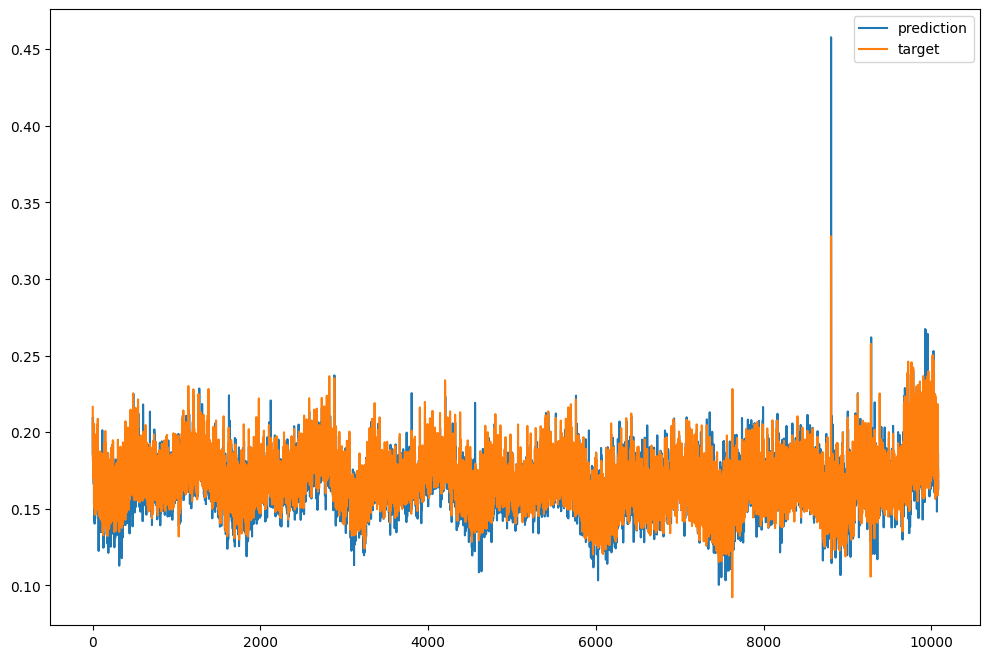

In [63]:
target=list(target.values.reshape(-1))

fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

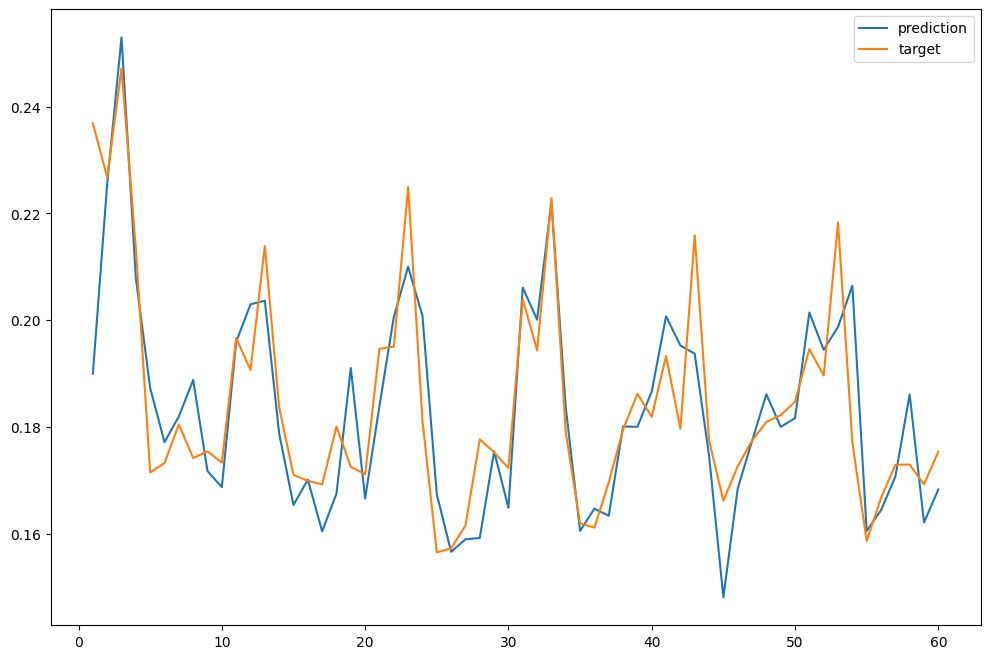

In [64]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1))
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

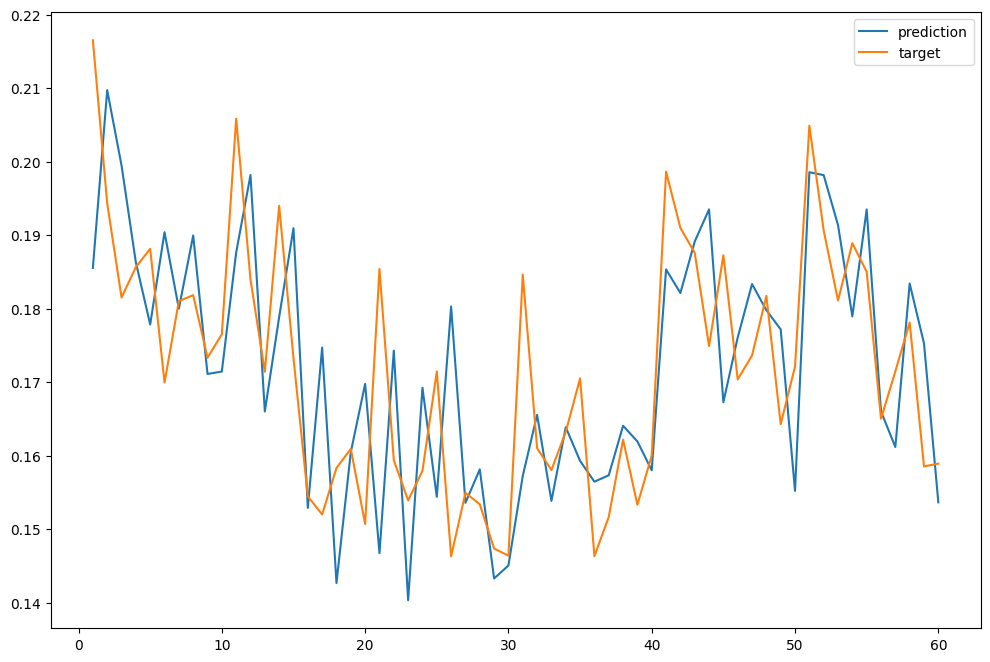

In [65]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [66]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                      FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')

SMAPE 5.2421897649765015 %
RMSE 0.012420222163200378
MAPE 5.243834853172302 %


In [67]:
target

[0.216504,
 0.19432,
 0.181504,
 0.18564,
 0.188136,
 0.169928,
 0.181008,
 0.181824,
 0.173304,
 0.176504,
 0.205824,
 0.18396,
 0.171392,
 0.193992,
 0.17324,
 0.15444,
 0.151992,
 0.15832,
 0.160896,
 0.150688,
 0.185384,
 0.159376,
 0.153896,
 0.157912,
 0.171448,
 0.146296,
 0.154928,
 0.153368,
 0.147352,
 0.146376,
 0.184632,
 0.161,
 0.158032,
 0.163216,
 0.170496,
 0.146312,
 0.151656,
 0.16216,
 0.153304,
 0.160008,
 0.198624,
 0.190976,
 0.187584,
 0.174904,
 0.187256,
 0.17036,
 0.173616,
 0.181728,
 0.164272,
 0.17212,
 0.20488,
 0.190616,
 0.181096,
 0.188904,
 0.185008,
 0.165008,
 0.171456,
 0.178104,
 0.158528,
 0.158896,
 0.20876,
 0.193304,
 0.179312,
 0.181544,
 0.180384,
 0.161056,
 0.16776,
 0.16932,
 0.170888,
 0.14888,
 0.184864,
 0.174064,
 0.166296,
 0.15968,
 0.172392,
 0.146552,
 0.146224,
 0.14824,
 0.145208,
 0.148168,
 0.178864,
 0.168608,
 0.163344,
 0.163008,
 0.170496,
 0.148688,
 0.159864,
 0.162392,
 0.1642,
 0.143688,
 0.18736,
 0.166888,
 0.157056,

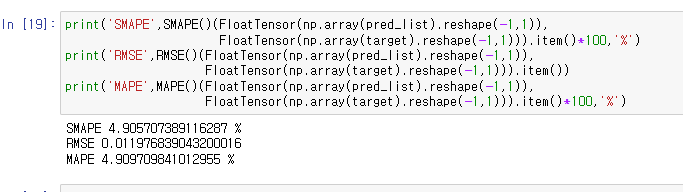
5,65 kernel일때
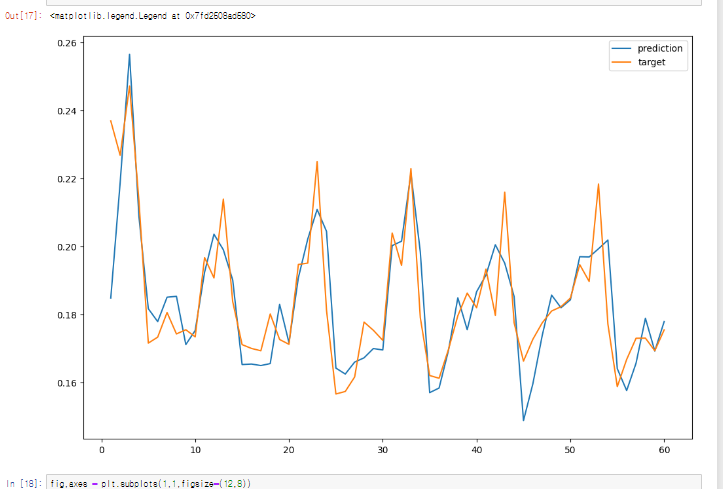
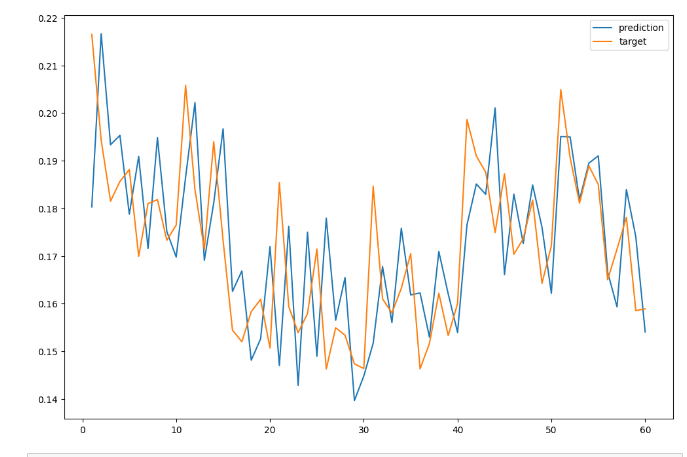